In [1]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset , random_split
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [2]:
rotations=[0,45,90,135,180,225,270,315]

In [3]:
# -----------------------------------------
# 2. Define transforms and load MNIST
# -----------------------------------------
class MinMaxScaler:
    def __call__(self, sample):
        return sample / 255

transform = transforms.Compose([
    transforms.ToTensor(),
    MinMaxScaler()
])

In [4]:
X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
X_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train_100 = Subset(X_train, range(100))  # First 100 samples for supervised
X_train_unsupervised = Subset(X_train, range(100, len(X_train)))  # Remaining samples for unsupervised



full_unsupervised_set = torch.utils.data.ConcatDataset([X_train_100, X_train_unsupervised])

train_size = int(0.9 * len(full_unsupervised_set))
val_size = len(full_unsupervised_set) - train_size

unsupervised_train_set, unsupervised_val_set = random_split(full_unsupervised_set, [train_size, val_size])


print(f"Unsupervised training set: {len(unsupervised_train_set)} samples")
print(f"Unsupervised validation set: {len(unsupervised_val_set)} samples")


Unsupervised training set: 54000 samples
Unsupervised validation set: 6000 samples


In [5]:
# -----------------------------------------
# 3. Define RotationDataset for Unsupervised Learning
# -----------------------------------------

class RotationDataset(torch.utils.data.Dataset):
    """Dataset that generates rotated versions of images with rotation labels (0°, 90°)."""
    def __init__(self, dataset,rotations):
        self.dataset = dataset
        self.rotations = rotations
        self.rotations_label = {element: index for index, element in enumerate(rotations)}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]

        rotation_angle = random.choice(rotations)
        rotated_image = transforms.functional.rotate(image, rotation_angle)
        rotation_label=self.rotations_label[rotation_angle]

        return rotated_image, rotation_label


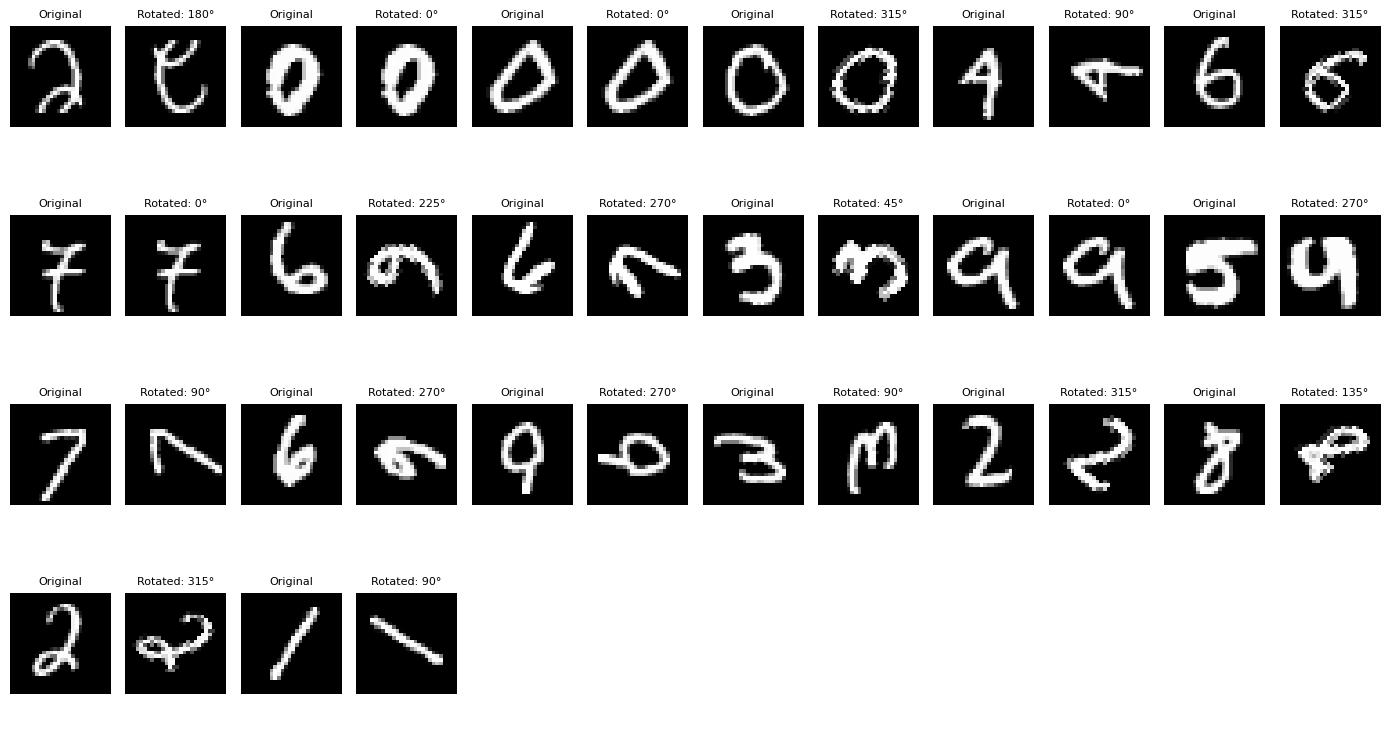

In [6]:
def visualize_original_and_rotated_images(dataset, num_images=12):
    """
    Visualize original and rotated images in a compact grid with rotation labels (0°, 90°).

    Args:
        dataset: The dataset containing images.
        num_images: Number of image pairs to visualize.
    """
    num_cols = 6
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols * 2, figsize=(14, num_rows * 2))

    for i in range(num_images):
        idx = torch.randint(0, len(dataset), (1,)).item()
        original_image, _ = dataset[idx]

        rotation_angle = random.choice(rotations)
        rotated_image = transforms.functional.rotate(original_image, rotation_angle)

        original_image = original_image.squeeze(0).numpy()
        rotated_image = rotated_image.squeeze(0).numpy()

        row, col = divmod(i, num_cols)
        original_col = col * 2
        rotated_col = col * 2 + 1

        axes[row, original_col].imshow(original_image, cmap='gray')
        axes[row, original_col].set_title("Original", fontsize=8)
        axes[row, original_col].axis('off')

        axes[row, rotated_col].imshow(rotated_image, cmap='gray')
        axes[row, rotated_col].set_title(f"Rotated: {rotation_angle}°", fontsize=8)
        axes[row, rotated_col].axis('off')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_original_and_rotated_images(X_train_unsupervised, num_images=20)


In [7]:
# -----------------------------------------
# 4. Define RotNet Model for Rotation Prediction
# -----------------------------------------
class RotNet(nn.Module):
    """RotNet model for self-supervised rotation prediction."""
    def __init__(self, num_classes=4):
        super(RotNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.rotation_head = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.view(x.size(0), -1)
        x = self.rotation_head(x)
        return x


In [8]:
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Initialize TensorBoard
writer = SummaryWriter(log_dir="runs/rotnet_training")

def train_rotnet(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)
        for step, (images, rotation_labels) in enumerate(train_bar):
            images, rotation_labels = images.cuda(), rotation_labels.cuda()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, rotation_labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Log gradients for each parameter
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    writer.add_scalar(f"Gradients/{name}", param.grad.abs().mean().item(), epoch * len(train_loader) + step)

            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == rotation_labels).sum().item()
            total += rotation_labels.size(0)

            # Log training loss and accuracy to TensorBoard
            writer.add_scalar("Train/Loss", loss.item(), epoch * len(train_loader) + step)
            writer.add_scalar("Train/Accuracy", (correct / total) * 100, epoch * len(train_loader) + step)

            # Update progress bar
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Validation step
        model.eval()
        val_correct = 0
        val_total = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=True)
        with torch.no_grad():
            for step, (images, rotation_labels) in enumerate(val_bar):
                images, rotation_labels = images.cuda(), rotation_labels.cuda()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, rotation_labels)

                _, predicted = torch.max(outputs, 1)
                val_total += rotation_labels.size(0)
                val_correct += (predicted == rotation_labels).sum().item()

                # Log validation loss to TensorBoard
                writer.add_scalar("Validation/Loss", loss.item(), epoch * len(val_loader) + step)

        val_accuracy = 100 * val_correct / val_total

        # Log validation accuracy to TensorBoard
        writer.add_scalar("Validation/Accuracy", val_accuracy, epoch)

        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}, Train Accuracy: {correct/total*100:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    # Close the TensorBoard writer
    writer.close()


2024-11-25 17:32:22.393100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732552342.407746 2203631 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732552342.412129 2203631 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 17:32:22.428273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.3) or cha

In [9]:
# Check a few samples from the dataset
for idx in range(5):
    image, label = RotationDataset(unsupervised_train_set,rotations=rotations)[idx]
    print(f"Sample {idx}: Label = {label}, Image shape = {image.shape}")


Sample 0: Label = 1, Image shape = torch.Size([1, 28, 28])
Sample 1: Label = 3, Image shape = torch.Size([1, 28, 28])
Sample 2: Label = 0, Image shape = torch.Size([1, 28, 28])
Sample 3: Label = 6, Image shape = torch.Size([1, 28, 28])
Sample 4: Label = 0, Image shape = torch.Size([1, 28, 28])


In [ ]:
rotnet = RotNet(num_classes=len(rotations)).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rotnet.parameters(), lr=0.0001)


unsupervised_train_loader = DataLoader(RotationDataset(unsupervised_train_set,rotations=rotations), batch_size=64, shuffle=True,num_workers=4,persistent_workers=True)
unsupervised_val_loader = DataLoader(RotationDataset(unsupervised_val_set,rotations=rotations), batch_size=64, shuffle=False,num_workers=4,persistent_workers=True)


# Train RotNe
train_rotnet(rotnet, unsupervised_train_loader, unsupervised_val_loader, criterion, optimizer, num_epochs=50)


Epoch 1/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 151.39it/s]


Epoch [1/500], Train Loss: 1755.1365, Train Accuracy: 12.69%, Validation Accuracy: 11.80%


Epoch 2/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 199.34it/s]


Epoch [2/500], Train Loss: 1755.0966, Train Accuracy: 12.77%, Validation Accuracy: 12.65%


Epoch 3/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 202.26it/s]


Epoch [3/500], Train Loss: 1755.1134, Train Accuracy: 12.59%, Validation Accuracy: 12.52%


Epoch 4/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 191.56it/s]


Epoch [4/500], Train Loss: 1268.1670, Train Accuracy: 44.54%, Validation Accuracy: 67.63%


Epoch 5/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 201.57it/s]


Epoch [5/500], Train Loss: 628.3598, Train Accuracy: 73.06%, Validation Accuracy: 75.53%


Epoch 6/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 186.59it/s]


Epoch [6/500], Train Loss: 505.1440, Train Accuracy: 77.89%, Validation Accuracy: 78.00%


Epoch 7/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 197.08it/s]


Epoch [7/500], Train Loss: 467.4632, Train Accuracy: 79.36%, Validation Accuracy: 79.67%


Epoch 8/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 166.05it/s]


Epoch [8/500], Train Loss: 441.9192, Train Accuracy: 80.29%, Validation Accuracy: 80.43%


Epoch 9/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 190.10it/s]


Epoch [9/500], Train Loss: 419.6429, Train Accuracy: 81.45%, Validation Accuracy: 81.53%


Epoch 10/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 184.24it/s]


Epoch [10/500], Train Loss: 403.3636, Train Accuracy: 82.15%, Validation Accuracy: 83.07%


Epoch 11/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 197.84it/s]


Epoch [11/500], Train Loss: 383.9244, Train Accuracy: 83.20%, Validation Accuracy: 83.30%


Epoch 12/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 195.45it/s]


Epoch [12/500], Train Loss: 369.8211, Train Accuracy: 83.81%, Validation Accuracy: 83.93%


Epoch 13/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 181.06it/s]


Epoch [13/500], Train Loss: 354.0126, Train Accuracy: 84.48%, Validation Accuracy: 85.20%


Epoch 14/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 173.77it/s]


Epoch [14/500], Train Loss: 340.9771, Train Accuracy: 85.26%, Validation Accuracy: 85.60%


Epoch 15/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 178.76it/s]


Epoch [15/500], Train Loss: 321.4945, Train Accuracy: 86.17%, Validation Accuracy: 85.73%


Epoch 16/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 197.22it/s]


Epoch [16/500], Train Loss: 307.8391, Train Accuracy: 86.71%, Validation Accuracy: 86.13%


Epoch 17/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 182.24it/s]


Epoch [17/500], Train Loss: 294.3453, Train Accuracy: 87.40%, Validation Accuracy: 87.68%


Epoch 18/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 198.18it/s]


Epoch [18/500], Train Loss: 280.8310, Train Accuracy: 88.01%, Validation Accuracy: 87.95%


Epoch 19/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 185.07it/s]


Epoch [19/500], Train Loss: 271.5940, Train Accuracy: 88.38%, Validation Accuracy: 88.72%


Epoch 20/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 176.29it/s]


Epoch [20/500], Train Loss: 260.1634, Train Accuracy: 88.91%, Validation Accuracy: 89.55%


Epoch 21/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 194.88it/s]


Epoch [21/500], Train Loss: 252.0969, Train Accuracy: 89.26%, Validation Accuracy: 89.43%


Epoch 22/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 201.62it/s]


Epoch [22/500], Train Loss: 239.6102, Train Accuracy: 89.79%, Validation Accuracy: 90.23%


Epoch 23/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 182.90it/s]


Epoch [23/500], Train Loss: 232.9310, Train Accuracy: 90.09%, Validation Accuracy: 90.57%


Epoch 24/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 210.98it/s]


Epoch [24/500], Train Loss: 223.4724, Train Accuracy: 90.43%, Validation Accuracy: 90.98%


Epoch 25/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 203.65it/s]


Epoch [25/500], Train Loss: 213.9481, Train Accuracy: 90.99%, Validation Accuracy: 90.32%


Epoch 26/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 199.77it/s]


Epoch [26/500], Train Loss: 210.4565, Train Accuracy: 91.17%, Validation Accuracy: 91.47%


Epoch 27/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 194.28it/s]


Epoch [27/500], Train Loss: 205.4921, Train Accuracy: 91.38%, Validation Accuracy: 91.15%


Epoch 28/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 181.33it/s]


Epoch [28/500], Train Loss: 197.3297, Train Accuracy: 91.67%, Validation Accuracy: 92.05%


Epoch 29/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 207.04it/s]


Epoch [29/500], Train Loss: 191.8244, Train Accuracy: 91.87%, Validation Accuracy: 91.25%


Epoch 30/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 221.55it/s]


Epoch [30/500], Train Loss: 186.4703, Train Accuracy: 92.19%, Validation Accuracy: 92.42%


Epoch 31/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 175.91it/s]


Epoch [31/500], Train Loss: 180.9152, Train Accuracy: 92.33%, Validation Accuracy: 93.05%


Epoch 32/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 207.29it/s]


Epoch [32/500], Train Loss: 178.7389, Train Accuracy: 92.54%, Validation Accuracy: 92.07%


Epoch 33/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 184.47it/s]


Epoch [33/500], Train Loss: 173.1634, Train Accuracy: 92.68%, Validation Accuracy: 93.27%


Epoch 34/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 186.52it/s]


Epoch [34/500], Train Loss: 168.9402, Train Accuracy: 92.95%, Validation Accuracy: 92.63%


Epoch 35/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 190.74it/s]


Epoch [35/500], Train Loss: 162.5105, Train Accuracy: 93.11%, Validation Accuracy: 92.90%


Epoch 36/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 198.76it/s]


Epoch [36/500], Train Loss: 161.1660, Train Accuracy: 93.19%, Validation Accuracy: 92.72%


Epoch 37/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 186.61it/s]


Epoch [37/500], Train Loss: 157.3504, Train Accuracy: 93.32%, Validation Accuracy: 93.82%


Epoch 38/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 192.40it/s]


Epoch [38/500], Train Loss: 151.5487, Train Accuracy: 93.68%, Validation Accuracy: 90.97%


Epoch 39/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 202.11it/s]


Epoch [39/500], Train Loss: 150.5111, Train Accuracy: 93.65%, Validation Accuracy: 93.62%


Epoch 40/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 176.45it/s]


Epoch [40/500], Train Loss: 147.3362, Train Accuracy: 93.80%, Validation Accuracy: 93.70%


Epoch 41/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 190.12it/s]


Epoch [41/500], Train Loss: 147.4374, Train Accuracy: 93.87%, Validation Accuracy: 93.88%


Epoch 42/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 194.57it/s]


Epoch [42/500], Train Loss: 143.1140, Train Accuracy: 94.09%, Validation Accuracy: 94.07%


Epoch 43/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 178.06it/s]


Epoch [43/500], Train Loss: 139.3708, Train Accuracy: 94.21%, Validation Accuracy: 94.73%


Epoch 44/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 175.23it/s]


Epoch [44/500], Train Loss: 140.4652, Train Accuracy: 94.12%, Validation Accuracy: 94.62%


Epoch 45/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 196.07it/s]


Epoch [45/500], Train Loss: 134.5226, Train Accuracy: 94.50%, Validation Accuracy: 93.83%


Epoch 46/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 194.64it/s]


Epoch [46/500], Train Loss: 131.3357, Train Accuracy: 94.52%, Validation Accuracy: 94.68%


Epoch 47/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 201.56it/s]


Epoch [47/500], Train Loss: 130.2708, Train Accuracy: 94.44%, Validation Accuracy: 94.07%


Epoch 48/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 192.96it/s]


Epoch [48/500], Train Loss: 126.4870, Train Accuracy: 94.68%, Validation Accuracy: 95.22%


Epoch 49/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 143.94it/s]


Epoch [49/500], Train Loss: 127.3727, Train Accuracy: 94.65%, Validation Accuracy: 95.20%


Epoch 50/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 189.18it/s]


Epoch [50/500], Train Loss: 126.4757, Train Accuracy: 94.67%, Validation Accuracy: 95.13%


Epoch 51/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 138.56it/s]


Epoch [51/500], Train Loss: 123.2810, Train Accuracy: 94.86%, Validation Accuracy: 94.65%


Epoch 52/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 185.97it/s]


Epoch [52/500], Train Loss: 121.8953, Train Accuracy: 94.93%, Validation Accuracy: 95.57%


Epoch 53/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 196.26it/s]


Epoch [53/500], Train Loss: 117.4361, Train Accuracy: 95.20%, Validation Accuracy: 95.27%


Epoch 54/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 182.96it/s]


Epoch [54/500], Train Loss: 117.5173, Train Accuracy: 95.11%, Validation Accuracy: 95.65%


Epoch 55/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 211.18it/s]


Epoch [55/500], Train Loss: 115.9491, Train Accuracy: 95.15%, Validation Accuracy: 95.12%


Epoch 56/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 179.44it/s]


Epoch [56/500], Train Loss: 114.8949, Train Accuracy: 95.29%, Validation Accuracy: 95.38%


Epoch 57/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 171.95it/s]


Epoch [57/500], Train Loss: 113.2826, Train Accuracy: 95.32%, Validation Accuracy: 95.28%


Epoch 58/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 189.35it/s]


Epoch [58/500], Train Loss: 111.8292, Train Accuracy: 95.46%, Validation Accuracy: 95.70%


Epoch 59/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 187.19it/s]


Epoch [59/500], Train Loss: 108.1251, Train Accuracy: 95.44%, Validation Accuracy: 95.50%


Epoch 60/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 203.98it/s]


Epoch [60/500], Train Loss: 109.8098, Train Accuracy: 95.44%, Validation Accuracy: 95.70%


Epoch 61/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 199.29it/s]


Epoch [61/500], Train Loss: 107.4145, Train Accuracy: 95.50%, Validation Accuracy: 96.05%


Epoch 62/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 190.03it/s]


Epoch [62/500], Train Loss: 108.1581, Train Accuracy: 95.44%, Validation Accuracy: 95.95%


Epoch 63/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 176.33it/s]


Epoch [63/500], Train Loss: 107.0431, Train Accuracy: 95.52%, Validation Accuracy: 96.10%


Epoch 64/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 179.38it/s]


Epoch [64/500], Train Loss: 101.6750, Train Accuracy: 95.75%, Validation Accuracy: 96.23%


Epoch 65/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 188.71it/s]


Epoch [65/500], Train Loss: 102.2523, Train Accuracy: 95.70%, Validation Accuracy: 95.45%


Epoch 66/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 190.56it/s]


Epoch [66/500], Train Loss: 103.9160, Train Accuracy: 95.71%, Validation Accuracy: 96.00%


Epoch 67/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 201.88it/s]


Epoch [67/500], Train Loss: 100.5900, Train Accuracy: 95.72%, Validation Accuracy: 95.90%


Epoch 68/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 193.38it/s]


Epoch [68/500], Train Loss: 100.6941, Train Accuracy: 95.74%, Validation Accuracy: 95.25%


Epoch 69/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 202.72it/s]


Epoch [69/500], Train Loss: 100.4258, Train Accuracy: 95.71%, Validation Accuracy: 96.18%


Epoch 70/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 177.42it/s]


Epoch [70/500], Train Loss: 98.1599, Train Accuracy: 95.92%, Validation Accuracy: 96.37%


Epoch 71/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 196.63it/s]


Epoch [71/500], Train Loss: 95.2565, Train Accuracy: 96.00%, Validation Accuracy: 95.80%


Epoch 72/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 200.74it/s]


Epoch [72/500], Train Loss: 96.8005, Train Accuracy: 95.93%, Validation Accuracy: 95.35%


Epoch 73/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 190.13it/s]


Epoch [73/500], Train Loss: 93.8577, Train Accuracy: 96.11%, Validation Accuracy: 96.32%


Epoch 74/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 204.60it/s]


Epoch [74/500], Train Loss: 94.0211, Train Accuracy: 96.06%, Validation Accuracy: 95.17%


Epoch 75/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 181.45it/s]


Epoch [75/500], Train Loss: 94.3136, Train Accuracy: 96.03%, Validation Accuracy: 96.32%


Epoch 76/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 183.13it/s]


Epoch [76/500], Train Loss: 93.2047, Train Accuracy: 96.24%, Validation Accuracy: 96.47%


Epoch 77/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 173.88it/s]


Epoch [77/500], Train Loss: 93.9925, Train Accuracy: 96.08%, Validation Accuracy: 96.22%


Epoch 78/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 151.48it/s]


Epoch [78/500], Train Loss: 92.5534, Train Accuracy: 96.13%, Validation Accuracy: 96.10%


Epoch 79/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 179.02it/s]


Epoch [79/500], Train Loss: 91.5202, Train Accuracy: 96.17%, Validation Accuracy: 96.48%


Epoch 80/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 181.19it/s]


Epoch [80/500], Train Loss: 90.1491, Train Accuracy: 96.27%, Validation Accuracy: 95.87%


Epoch 81/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 189.88it/s]


Epoch [81/500], Train Loss: 87.8516, Train Accuracy: 96.34%, Validation Accuracy: 95.83%


Epoch 82/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 190.94it/s]


Epoch [82/500], Train Loss: 87.6976, Train Accuracy: 96.34%, Validation Accuracy: 96.45%


Epoch 83/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 190.44it/s]


Epoch [83/500], Train Loss: 87.5356, Train Accuracy: 96.42%, Validation Accuracy: 96.30%


Epoch 84/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 195.18it/s]


Epoch [84/500], Train Loss: 87.9905, Train Accuracy: 96.29%, Validation Accuracy: 96.83%


Epoch 85/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 199.59it/s]


Epoch [85/500], Train Loss: 87.9153, Train Accuracy: 96.39%, Validation Accuracy: 96.52%


Epoch 86/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 187.91it/s]


Epoch [86/500], Train Loss: 86.9077, Train Accuracy: 96.45%, Validation Accuracy: 96.92%


Epoch 87/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 189.79it/s]


Epoch [87/500], Train Loss: 85.5577, Train Accuracy: 96.39%, Validation Accuracy: 96.33%


Epoch 88/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 179.26it/s]


Epoch [88/500], Train Loss: 82.2737, Train Accuracy: 96.60%, Validation Accuracy: 96.37%


Epoch 89/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 191.21it/s]


Epoch [89/500], Train Loss: 84.2413, Train Accuracy: 96.52%, Validation Accuracy: 96.57%


Epoch 90/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 193.93it/s]


Epoch [90/500], Train Loss: 83.4298, Train Accuracy: 96.56%, Validation Accuracy: 96.27%


Epoch 91/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 187.10it/s]


Epoch [91/500], Train Loss: 82.9978, Train Accuracy: 96.61%, Validation Accuracy: 96.77%


Epoch 92/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 188.97it/s]


Epoch [92/500], Train Loss: 81.4971, Train Accuracy: 96.59%, Validation Accuracy: 96.45%


Epoch 93/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 202.02it/s]


Epoch [93/500], Train Loss: 82.3715, Train Accuracy: 96.62%, Validation Accuracy: 96.83%


Epoch 94/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 197.48it/s]


Epoch [94/500], Train Loss: 81.2557, Train Accuracy: 96.61%, Validation Accuracy: 96.57%


Epoch 95/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 178.07it/s]


Epoch [95/500], Train Loss: 82.4852, Train Accuracy: 96.58%, Validation Accuracy: 96.57%


Epoch 96/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 200.89it/s]


Epoch [96/500], Train Loss: 80.9868, Train Accuracy: 96.72%, Validation Accuracy: 96.53%


Epoch 97/500 [Validation]: 100%|██████████| 94/94 [00:00<00:00, 172.59it/s]


Epoch [97/500], Train Loss: 78.7500, Train Accuracy: 96.80%, Validation Accuracy: 96.22%


Epoch 98/500 [Training]:  56%|█████▌    | 474/844 [00:04<00:03, 107.22it/s, loss=0.1244]

In [ ]:
# -----------------------------------------
# 6. Define Classifier with Conv Head for Supervised Learning
# -----------------------------------------
class FeatureExtractor(nn.Module):
    """Extract features from the first two blocks of RotNet."""
    def __init__(self, rotnet):
        super(FeatureExtractor, self).__init__()
        self.block1 = rotnet.block1
        self.block2 = rotnet.block2

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x

class MNISTClassifierWithConvHead(nn.Module):
    """MNIST classifier with an additional convolutional block and fully connected layer."""
    def __init__(self):
        super(MNISTClassifierWithConvHead, self).__init__()
        self.conv_head = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_head(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
# -----------------------------------------
# 7. Train Classifier on Supervised Dataset
# -----------------------------------------
def train_classifier(feature_extractor, classifier, dataloader, criterion, optimizer, num_epochs=400):
    feature_extractor.eval()  # Freeze feature extractor
    classifier.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            with torch.no_grad():  # Extract features
                features = feature_extractor(images)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

feature_extractor = FeatureExtractor(rotnet).cuda()
classifier = MNISTClassifierWithConvHead().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Create DataLoader for supervised dataset
supervised_loader = DataLoader(X_train_100, batch_size=16, shuffle=True)

# Train Classifier
train_classifier(feature_extractor, classifier, supervised_loader, criterion, optimizer)

Epoch [1/400], Loss: 16.1503
Epoch [2/400], Loss: 16.0489
Epoch [3/400], Loss: 16.0162
Epoch [4/400], Loss: 15.9174
Epoch [5/400], Loss: 15.8645
Epoch [6/400], Loss: 15.7086
Epoch [7/400], Loss: 15.8226
Epoch [8/400], Loss: 15.9879
Epoch [9/400], Loss: 15.8090
Epoch [10/400], Loss: 15.7442
Epoch [11/400], Loss: 15.9757
Epoch [12/400], Loss: 15.8730
Epoch [13/400], Loss: 15.9691
Epoch [14/400], Loss: 15.8322
Epoch [15/400], Loss: 15.7787
Epoch [16/400], Loss: 15.8083
Epoch [17/400], Loss: 15.8769
Epoch [18/400], Loss: 15.7772
Epoch [19/400], Loss: 15.7928
Epoch [20/400], Loss: 15.9219
Epoch [21/400], Loss: 15.9172
Epoch [22/400], Loss: 15.7722
Epoch [23/400], Loss: 15.8466
Epoch [24/400], Loss: 15.9418
Epoch [25/400], Loss: 15.9615
Epoch [26/400], Loss: 15.7098
Epoch [27/400], Loss: 15.9274
Epoch [28/400], Loss: 15.7962
Epoch [29/400], Loss: 15.7250
Epoch [30/400], Loss: 16.0156
Epoch [31/400], Loss: 15.8223
Epoch [32/400], Loss: 15.8954
Epoch [33/400], Loss: 15.8536
Epoch [34/400], Los

In [ ]:
# -----------------------------------------
# 8. Evaluate Classifier on Test Set
# -----------------------------------------
def evaluate_classifier(feature_extractor, classifier, dataloader):
    feature_extractor.eval()
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            features = feature_extractor(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate Classifier
test_loader = DataLoader(X_test, batch_size=64, shuffle=False)
evaluate_classifier(feature_extractor, classifier, test_loader)

Test Accuracy: 11.35%
